# Preliminary Steps
These are some preliminary steps before addressing the task. Import some basic libraries and set a variable that will be used in multiple steps.

In [1]:
import re
import os
import sys
import zipfile
import urllib.request

import numpy as np
import pandas as pd
import tensorflow as tf

from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers

# Evaluation and plotting
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# utils
from functools import partial
from typing import List, Callable, Dict

np.random.seed(seed=100) #Define a seed for randomization, avoiding to get different placeholder or random embeddings each time

# Dataset
What follows are a series of methods and utilities for processing the dataset.

## Constant and utilities
Defining global variables and constants used to build, hanlde and tokenize the dataset

In [2]:
DATASET_NAME = "dependency_treebank" #Name of the folder that will be automatically created after extracting the dataset
DOCUMENT_EXTENSION = ".dp" #Extension of the document files to be read

USE_DOCUMENTS = False #True=Use documents; False = Use sentences (split documents into sentences)
file_end_name = "_documents" if USE_DOCUMENTS else "_sentences"

#List of paths to handle the dataset
DATASET_PATHS = {
    "url" : 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip', # Url to dowload the dataset
    "dataset_folder": os.path.join(os.getcwd(), "Datasets", "Original"), # Folder containing the original dataset data
    "dataset_path" : os.path.join(os.getcwd(), "Datasets", "Original", "dependency_treebank.zip"), # Path to zipped dataset
    "documents_path" : os.path.join(os.getcwd(), "Datasets", "Original", DATASET_NAME), # Folder containing extracted documents (NB: it is created automatically during the extraction)
    "dataframe_folder" : os.path.join(os.getcwd(), "Datasets", "Dataframes", DATASET_NAME), # Folder containing the dataframe data
    "dataframe_path" : os.path.join(os.getcwd(), "Datasets", "Dataframes", DATASET_NAME, DATASET_NAME + file_end_name + ".pkl") # Path to pickle save of built dataframe
}

TRAINING_DOCS = 100 #N. of documents to use in training set
VALIDATION_DOCS = 50 #N. of documents to use in validation set
TEST_DOCS = 49 #N. of documents to use in test set

PADDING = 0 #Value for padding
QUANTILE = 0.99 #Quantile used to catch a good max_tokens_length without wasting memory

##Folders creation
Create folders for the dataset and the dataframe files

In [3]:
def create_folders(paths: List[str]):
  '''
  Create the folders in paths list.

  Parameters:
  ----------
  paths: List[str]
    A list of all the folders to create
  '''

  for path in paths:
    if not os.path.exists(path):
      os.makedirs(path)

folders = [DATASET_PATHS["dataset_folder"],
           DATASET_PATHS["dataframe_folder"]]
           
create_folders(folders)

## Dataset download

In [4]:
def download_dataset(dataset_path: str):
  '''
  Download the dataset zip file into the specified path

  Parameters:
  ----------
  dataset_path: str
    Destination path
  '''
  if not os.path.exists(dataset_path):
      urllib.request.urlretrieve(DATASET_PATHS["url"], dataset_path)

      print("Successful download")

download_dataset(DATASET_PATHS["dataset_path"])

Successful download


## Dataset extraction

In [5]:
def extract_dataset(dataset_path: str,
                    dataset_folder: str,
                    documents_path: str):
  '''
  Extract dataset zip file.

  Parameters:
  -----------
  dataset_path: str
    Path of the zip file
  dataset_folder: str
    Path of the dataset
  documents_path: str
    Path containing the documents after extraction
  '''
  expected_docs_number = TRAINING_DOCS + VALIDATION_DOCS + TEST_DOCS

  #Extract only if there are less than 199 documents or the extraction's folder does not exist
  if not os.path.exists(documents_path) or len(os.listdir(documents_path))<expected_docs_number:
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_folder)

    print("Successful extraction")

extract_dataset(DATASET_PATHS["dataset_path"],DATASET_PATHS["dataset_folder"],DATASET_PATHS["documents_path"])

Successful extraction


##Preprocess
Define some methods that will be used for cleaning the data.

In [6]:
def preprocess(token: str) -> str:
	"""
	Calls the function that cleans the text
	Input: the string to process
	Output: the processed string
	"""
	token = text_to_lower(token)
	token = strip_text(token)
	return token

def text_to_lower(text: str) -> str:
	"""
	Returns the string in lower character
	Input: the string to process
	Output: the processed string
	"""
	return text.lower();

def strip_text(text: str) -> str:
	"""
	Removes any left or right spacing (including carriage return) from text.
	Example:
	Input: '  This assignment is cool\n'
	Output: 'This assignment is cool'
	"""

	return text.strip()

## Dataframe creation
This section is responsible for building a dataframe based on the dataset; using the format (split, document/sentence, labels).

Where:
1. **split** is a string value of type "train", "validation" or "test";
2. **document/sentence** is a a string containing tokens belonging to a full document or sentence separated by spaces;
3. **labels** is a string containing the correspondent labels to the document/sentence tokens separated by spaces.

In [7]:
TOKEN_SEPARATOR = " " #Character used to separate tokens in the dataframe
SENTENCE_SEPARATOR = "##" #Characters to signal the end of a sentence (if USE_DOCUMENTS=False)
WORDS_CONTAINER = "document" if USE_DOCUMENTS else "sentence"

def list_to_string(_list: List[str])->str :
	'''
	Convert a list of strings into a single string using a separator.

	Parameters:
	----------
	_list: List[str]
		A list of strings
	
	Returns:
	--------
	str:
		The union of the previous strings into a single one
	'''
	string = ""

	for index, value in enumerate(_list):
		string+=value
		if index!=len(_list)-1:
			string+=TOKEN_SEPARATOR #Separate each word in the string
	
	return string

def add_row_to_dataframe_rows(dataframe_rows: List,
                              split: str,
							  document: str,
							  labels: str):
	'''
	Add the elements of a single dataframe row into a specific dataframe.

	Parameters:
	-----------
	dataframe_rows: List
		Dataframe's rows
	split: str
		Split value (train, validation or test)
	document: str
		Document or sentence
	labels: str
		String containing the labels of a document or sentence
	'''
	if USE_DOCUMENTS:
		dataframe_row = {"split": split, WORDS_CONTAINER: document, "labels": labels}
		dataframe_rows.append(dataframe_row)
	else:
		sentences = document.split(SENTENCE_SEPARATOR)
		split_labels = labels.split(SENTENCE_SEPARATOR)
		#Add each sentences separately in the dataframe if using sentences
		for i in range(len(sentences)):
			dataframe_row = {"split": split, WORDS_CONTAINER: sentences[i], "labels": split_labels[i]}
			dataframe_rows.append(dataframe_row)
	
def rows_to_dataframe(rows: List)->pd.DataFrame:
	'''
	Convert a list of rows into a pandas Dataframe

	Parameters:
	-----------
	rows: List
		List of rows of type (split,document/sentence,labels)

	Returns:
	--------
	dataframe: pd.DataFrame
		A dataframe containing the given rows.
	'''
	dataframe = pd.DataFrame(rows)
	dataframe = dataframe[["split", WORDS_CONTAINER, "labels"]]

	return dataframe

def get_documents(path: str)->List[str]:
	'''
	Get a list of the document files inside the specified path.

	Parameters:
	----------
	path: str
		Path containing the documents

	Returns:
	--------
	documents: List[str]
		List of document files
	'''
	files = os.listdir(path)
	documents = filter(lambda name: (name.endswith(DOCUMENT_EXTENSION)), files) #Select only documents with the right extension
	documents = list(documents)
	documents.sort()
 
	return documents
 
def get_document_number(filename: str)->int:
	'''
	Get the number of the given document

	Parameters:
	----------
	filename: str
		Filename of the document
	
	Returns:
	--------
	int:
		Document's number
	'''
	return int(filename.split("_")[1].split(".")[0])
 
def extract_data_from_line(line: str)->(str,str):
	'''
	Extract token and label from a given line.

	Parameters:
	----------
	line: str
		A document/sentence line

	Returns:
	--------
	str, str:
		1. Token and label if line is not empty (\n)
		2. None, None if line is empty and USE_DOCUMENTS=True
		3. A couple of sentence separators if line is empty and USE_DOCUMENTS=False
			 to signal the end of a sentence
	'''
	if line != "\n":
		columns = line.split()
		token = columns[0] #The token is the first element of a line
		token = preprocess(token)
		label = columns[1] #The label is the second element of a line

		return token, label

	else:
		if USE_DOCUMENTS: #Ignore the empty line ("\n") if using documents
			return None, None
		else:
			return SENTENCE_SEPARATOR, SENTENCE_SEPARATOR #Mark the empy line ("\n") as the end of a sentence if using sentences

def process_document(document: str,
                     doc_number: int)->(str,List[str],List[str]):
	'''
	Read a document/sentence and extract split, tokens and labels data.

	Parameters:
	----------
	document: str
		Document to read
    doc_number: int
		Number of the document

	Returns:
		split, tokens and labels of the given document/sentence
	'''
	tokens = []
	labels = []
	split = ""

	try:
		if os.path.isfile(document):
			#Open the file
			with open(document, mode='r', encoding='utf-8') as text_file:

				#Split in different groups
				if doc_number <= TRAINING_DOCS:
					split = "train"
				elif doc_number <= TRAINING_DOCS+VALIDATION_DOCS:
					split = "validation"
				else:
					split = "test"

				#Extract tokens and labels line by line
				for line in text_file:
					token, label = extract_data_from_line(line)

					if token!=None and label!=None:
						tokens.append(token)
						labels.append(label)
		 
	except Exception as e:
                print('Failed to process %s. Reason: %s' % (document, e))
                sys.exit(0)

	return split, list_to_string(tokens), list_to_string(labels)

###Build/Load Dataframe
Use the previous methods to build and save the dataframe, or load the dataframe if already saved.

In [8]:
def build_dataframe(documents_path: str,
                    dataframe_path: str,
					               save=True)->pd.DataFrame:
	'''
	Build a dataframe and optionally save it.

	Parameters:
	----------
	documents_path: str
		Path containing the documents
    dataframe_path: str
		Path to save the dataframe in
	save: bool
		Flag to decide on saving or not the built dataframe

	Returns:
	--------
	dataframe: pd.DataFrame
		The built dataframe
	'''
	documents = get_documents(documents_path)
	dataframe_rows = []

	#Iterate along the files
	for filename in documents:
		document = os.path.join(documents_path, filename)
		doc_number = get_document_number(filename)

		split, tokens, labels = process_document(document, doc_number)
		add_row_to_dataframe_rows(dataframe_rows,split,tokens,labels)

	#Transform the list of rows in a proper dataframe
	dataframe = rows_to_dataframe(dataframe_rows)
	print("Dataframe built successfully")
	
	#Save the dataframe
	if save:
		dataframe.to_pickle(dataframe_path)
		print("Dataframe saved successfully")
 
	return dataframe

def load_dataframe(documents_path: str,
                   dataframe_path: str,
									 force_rebuild = False)->pd.DataFrame:
	'''
	Load the dataframe from memory if it is possible, or build a new one.

	Parameters:
	----------
	documents_path: str
		Path containing the documents
    dataframe_path: str
		Path to load the dataframe from
	force_rebuild: bool
		Flag to force the rebuild of the dataframe even if a saved copy exists

	Returns:
	--------
	pd.DataFrame
		The built or loaded dataframe
	'''
	if not os.path.exists(dataframe_path) or force_rebuild:
		return build_dataframe(documents_path, dataframe_path)
	else:
		return pd.read_pickle(dataframe_path) #Load dataframe

##Split dataset
Split dataset into train, validation and test

In [9]:
df = load_dataframe(DATASET_PATHS["documents_path"],DATASET_PATHS["dataframe_path"], True)

#Test
#print(df.iloc[1][WORDS_CONTAINER])
#print(df.iloc[1]["labels"])

training_set = df.loc[df["split"] == "train"]
validation_set = df.loc[df["split"] == "validation"]
test_set = df.loc[df["split"] == "test"]

Dataframe built successfully
Dataframe saved successfully


What follows is the countplot of the classes that can be found in the training set.

This is useful for depicting that the training set is extremely unbalanced.

<a name="001"></a>

Text(0.5, 1.0, 'Train set labels distribution')

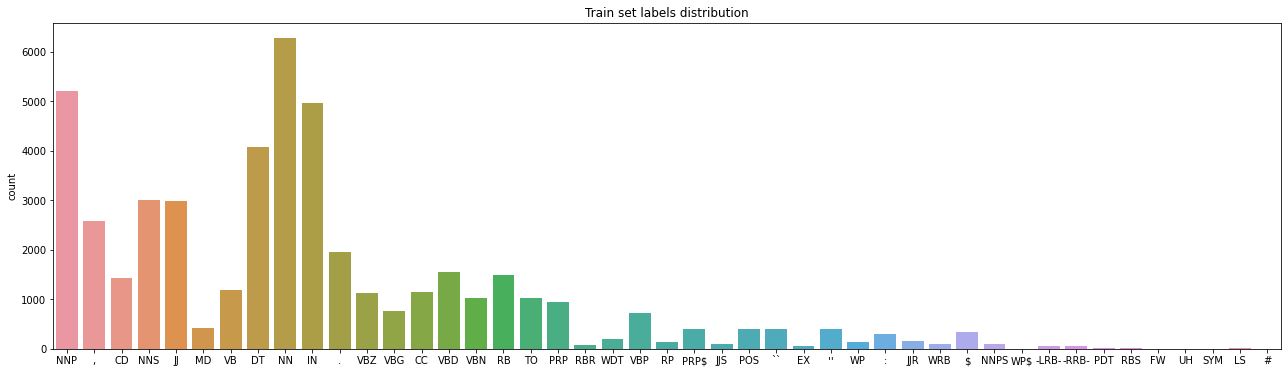

In [10]:
train_labels = []
for sample_labels in training_set['labels']:  
    train_labels.extend(sample_labels.split())

plt.figure(figsize=(22, 6))
sns.countplot(x=train_labels).set_title('Train set labels distribution')

##Tokenization and vocabularies
Here each set is passed through a tokenization process, which also allows to define the vocabulary of each set and also their vocabulary size. Furthermore the maximum length of a token sequence is defined and the labels are exteacted from the sets.

In [11]:
STARTING_TOKEN = 1 #First value to start the tokenization on (0 is already used as padding value)

def get_tokenizer(corpus: List[str],
                  starting_dict=None)->Dict[str,int]:
  '''
  Create or expand (given an existing dictionary) a tokenization dictionary
  that associates an integer to each word.

  Parameters:
  -----------
  corpus: List[str]
    Text to examine searching for new words to add into the dictionary
  starting_dict: Dict[str,int]
    An already filled dictionary to further expand (optional)

  Returns:
  --------
  words_to_tokens: Dict[str,int]
    1. A filled dictionary that associates an integer to each word (if starting_dict=None);
    2. An expanded dictionary that associates an integer to each new word (if starting_dict is not None)
  '''

  #Copy the original dictionary to keep it save from updates
  words_to_tokens = {} if starting_dict==None else starting_dict.copy()

  for text in corpus:
    words = text.split()
    for word in words:
      if not word in words_to_tokens:
        words_to_tokens[word] = len(words_to_tokens)+STARTING_TOKEN

  return words_to_tokens

def tokenize(word: str,
             words_to_tokens: Dict[str,int])->int:
  '''
  Get the integer value of a given token.

  Parameters:
  -----------
  word: str
    Token
  words_to_tokens: Dict[str,int]
    Tokenization dictionary

  Returns:
  -------
  int:
    Value associated to the token
  '''
  return words_to_tokens[word]

def detokenize(token:int,
               words_to_tokens: Dict[str,int])->str:
  '''
  Get the token-word of a given token-value.

  Parameters:
  -----------
  token: int
    Tokenized word
  words_to_tokens: Dict[str,int]
    Tokenization dictionary

  Returns:
  -------
  str:
    Word associated to the token-value
  '''
  val_list = list(words_to_tokens.values())
  key_list = list(words_to_tokens.keys())

  position = val_list.index(token)

  return key_list[position]

  #return words_to_tokens.index(token)

def tokenize_string(string: str,
                    words_to_tokens: Dict[str,int],
                    max_length: int)->List[int]:

  '''
  Get the tokenized sequence of a string of separated tokens (document/sentence).

  Parameters:
  string: str
    String of separated tokens (document or sentence)
  words_to_tokens: Dict[str,int]
    Tokenization dictionary
  max_length: int
    Tokenization length

  Returns:
    List[int]:
      A list of token-values where each one is the tokenized value of a token
      int the input-string.
      The list is padded if its length is below the max_length.
      The list is truncated if its length is above the max_length.
  '''
  tokens = string.split()
  tokenized_sequence = [tokenize(token, words_to_tokens)  for token in tokens]
  length_diff = max_length-len(tokenized_sequence)

  if length_diff==0: # Return the same sequence if it has the requested size
    return tokenized_sequence
  elif length_diff<0: # Return the truncated sequence if it exceeds the requested size
    return tokenized_sequence[0:max_length]
  else: # Return the padded sequence if it has an inferior size than the expected one
    return np.pad(tokenized_sequence, (PADDING, length_diff), 'constant').tolist()

#Define corpus
train_text = training_set[WORDS_CONTAINER].tolist()
val_text = validation_set[WORDS_CONTAINER].tolist()
test_text = test_set[WORDS_CONTAINER].tolist()

#Define labels
train_labels = training_set["labels"].tolist()
val_labels = validation_set["labels"].tolist()
test_labels = test_set["labels"].tolist()

#Token dictionaries
train_tokens = get_tokenizer(train_text)
val_tokens = get_tokenizer(val_text, starting_dict = train_tokens)
test_tokens = get_tokenizer(test_text, starting_dict = val_tokens)

#Vocabularies
train_vocab = train_tokens.keys()
val_vocab = val_tokens.keys()
test_vocab = test_tokens.keys()

#Vocab sizes
train_vocab_size = len(train_vocab)
val_vocab_size = len(val_vocab)
test_vocab_size = len(test_vocab)

#Max lenght of a token sequence
corpus = train_text+val_text+test_text
n_tokens = [len(doc.split()) for doc in corpus]
max_length = int(np.quantile(n_tokens,QUANTILE))
print(max_length)

#Tokenized sets
train_tokenized = np.array(list(map(lambda string: tokenize_string(string, train_tokens,max_length),train_text)))
val_tokenized = np.array(list(map(lambda string: tokenize_string(string, val_tokens,max_length),val_text)))
test_tokenized = np.array(list(map(lambda string: tokenize_string(string, test_tokens,max_length),test_text)))

55


##Labels encoding
Functions for encoding and decoding of labels from string representation to a numerical one are implemented here.

In [12]:
def get_categorical_encoding(labels_list: List[str])->Dict[str,int]:
  '''
  Create the categorical encoding of a list of labels.

  Parameters:
  ----------
  labels_list: List[str]
    List of all labels
  
  Returns:
  --------
  encoding: Dict[str,int]
    A dictionary that associates a unique integer value to each possible
    different label
  '''
  encoding = {}

  for label_group in labels_list:
    labels = label_group.split()
    for label in labels:
      if not label in encoding:
        encoding[label] = len(encoding) + 1 # 0 is padding reserved

  return encoding

def encode_label(label: str,
                 encoding: Dict[str,int])->int:
  '''
  Encode a label with its corresponding encoding.

  Parameters:
  -----------
  label: str
    Label to encode
  encoding: Dict[str,int]
    Encoding dictionary of all possible labels

  Returns:
  --------
  int:
    Encoding value of the given label
  '''
  return encoding[label]

def decode_label(value,
                 encoding: Dict[str,int])->str:
  '''
  Decode a label-encoding value with its corresponding label.

  Parameters:
  -----------
  value
    Value to decode
  encoding: Dict[str,int]
    Encoding dictionary of all possible labels

  Returns:
  --------
  str:
    Corresponding decoded label
  '''
  val_list = list(encoding.values())
  key_list = list(encoding.keys())

  position = val_list.index(value)

  return key_list[position]

def encode_string_of_labels(string:str,
                            encoding:Dict[str,int], max_length:int)->np.array:
  '''
  Get the encoded sequence of a string of separated labels.

  Parameters:
  -----------
  string: str
    String of separated labels
  encoding: Dict[str,int]
    Encoding dictionary of all possible labels
  max_length: int
    Tokenization length

  Returns:
  -----------
    np.array:
      Numpy array of encoded labels where each one is the encoded version of the corresponding label
      int the input-string.
      The array is padded if its length is below the max_length.
      The array is truncated if its length is above the max_length.
  '''
  labels = string.split()
  encoded_sequence = [encode_label(label, encoding)  for label in labels]

  length_diff = max_length-len(encoded_sequence)
  if length_diff==0:
    return np.array(encoded_sequence) # Return the same sequence if it has the requested size
  elif length_diff<0:
    return np.array(encoded_sequence[0:max_length]) # Return the truncated sequence if it exceeds the requested size
  else:
    return np.pad(encoded_sequence, (PADDING, length_diff), 'constant') # Return the padded sequence if it has an inferior size than the expected one

def is_punctuation_label(label: str)->bool:
  '''
  Return True if the label is a punctuation label and False otherwise.

  Parameters:
  ----------
  label: str
    Label to classify as a punctuation one or not

  Returns:
  --------
  bool:
    True if the label is a punctuation label, False otherwise
  '''
  punctuation_labels = ['``', '#', '$', "''", ',', '-LRB-', '-RRB-', '.', ':']
  
  return label in punctuation_labels

labels_list = training_set["labels"].tolist() + validation_set["labels"].tolist() + test_set["labels"].tolist()
labels_encoding = get_categorical_encoding(labels_list) 

# GloVe
This section is the one responsible for the implementation of the GloVe embedding system.

## Constants and utilities


In [13]:
URL_BASE = "https://nlp.stanford.edu/data" #Location of the pre-trained GloVe's files
GLOVE_VERSION = "6B"

EMBEDDING_SIZE = 200 #The dimensionality of the embeddings; to be tested

#List of paths to download and extract GloVe's files
PATHS = {
    "url": URL_BASE + "/glove." + GLOVE_VERSION + ".zip",
    "glove_path": os.path.join(os.getcwd(),"Glove",GLOVE_VERSION),
    "glove_zip": os.path.join(os.getcwd(),"Glove", GLOVE_VERSION, "glove."+GLOVE_VERSION+".zip"),
    "glove_file": os.path.join(os.getcwd(),"Glove", GLOVE_VERSION, "glove."+GLOVE_VERSION+"."+str(EMBEDDING_SIZE)+"d.txt")
}

#Determine which OOV method to adopt; choose one between "Mean", "Random" and "Placeholder"
OOV_METHOD = "Mean" 

# Constant value used when OOV_METHOD = 'Placeholder'. Randomly initialized.
PLACEHOLDER = np.random.uniform(low=-0.05, high=0.05, size=EMBEDDING_SIZE)

## Download
In this part the presence of the GloVe file is checked. In case of a negative response, it will be downloaded and extracted.

In [14]:
def setup_files():
  '''
  Create the folder if it does not exist.
  Then download the zip file from the web archive if it does not exist.
  Finally exctract the zip file of the GloVe txt file does not exist in the folder.
  '''

  if not os.path.exists(PATHS["glove_path"]):
    os.makedirs(PATHS["glove_path"])

  if not os.path.exists(PATHS["glove_file"]):
    if not os.path.exists(PATHS["glove_zip"]):
      download_glove(PATHS["url"])

    extract_glove(PATHS["glove_zip"],PATHS["glove_path"])

def download_glove(url: str):
    '''
    Download GloVe's zip file from the web.
    '''

    urllib.request.urlretrieve(url, PATHS['glove_zip'])
    print("Successful download")

def extract_glove(zip_file: str,
                  glove_path: str):
  
    '''
    Extract GloVe's zip file.
    '''
  
    with zipfile.ZipFile(PATHS["glove_zip"], 'r') as zip_ref:
      zip_ref.extractall(path=PATHS["glove_path"])
      print("Successful extraction")

## Initialization
In this step, the downloaded GloVe file is loaded into an embedding vocabulary

In [15]:
def load_model(glove_file: str) ->Dict:
  '''
  Open GloVe's txt file and store each of its contained words
  into a dictionary along with their correspondent embedding weights.

  Parameters:
  ----------
  glove_file : str
      GloVe's txt file path.

  Returns:
  -------
  vocabulary: Dict
      GloVe's vocabulary

  '''
  print("Loading GloVe Model...")

  with open(glove_file, encoding="utf8" ) as f: #Open the txt file
      lines = f.readlines() #Read the file line by line

  vocabulary = {}
  for line in lines:
      splits = line.split()
      #Save the first part of the line (word) as the dictionary's key and the second part (the embedding) as the key
      vocabulary[splits[0]] = np.array([float(val) for val in splits[1:]])

  print("GloVe model loaded")

  return vocabulary

## OOV
In this section, some possible "Out Of Vocabulary" handling methods are implemented, along with other OOV-related functions.

In [16]:
def random_embedding(embedding_size: int) ->np.array:
    '''
    Return a numpy array with random values sampled from a uniform distribution.

    Parameters:
    ----------
    embedding_size: int
        The embedding size that is used as the size of the numpy array.

    Results:
    -------
    np.array
    A randomized numpy array.
    '''
    return np.random.uniform(low=-0.05, high=0.05, size=embedding_size)

def placeholder_embedding() ->np.ndarray:
    '''
    Return the placeholder embedding as the OOV embedding.

    Returns:
    --------
    np.ndarray:
        Placeholder embedding
    '''
    return PLACEHOLDER

def neighbours_mean_embedding(word: str,
                              glove_embedding: Dict[str,int],
                              sentences: List[str],
                              labels_list: List[str])->np.array:
    '''
    Compute the embedding of an OOV word by taking the mean
    of its neighbours.

    Parameters:
    ---------
    word: str
        The OOV that needs to be embedded.
    glove_embedding: Dict[str, int]
        GloVe's embedding.
    sentences: List[str]
        A list of all the sentences/documents (strings of separated words) in the current set.

    Returns:
    -------
    mean: int
        The mean of the embedding values of OOV-word's neighbours.
    '''
    neighbours = set()

    for sentence,labels_group in zip(sentences,labels_list):
        tokens = sentence.split()
        labels = labels_group.split()
        for index, token in enumerate(tokens):
            if word == token:
                if index!=0: #Check if a left_neighbour exists
                    left_neighbour = tokens[index-1]
                    if left_neighbour in glove_embedding and not is_punctuation_label(labels[index-1]): #Consider only words that are not OOV and not punctuation
                        neighbours.add(left_neighbour)
                if index!=len(tokens)-1: #Check if a right_neighbour exists
                    right_neighbour = tokens[index+1]
                    if right_neighbour in glove_embedding and not is_punctuation_label(labels[index+1]): #Consider only words that are not OOV and not punctuation
                        neighbours.add(right_neighbour)

    neighbours_embeddings = np.array([glove_embedding[neighbour] for neighbour in neighbours])
    #Return the mean of the neighbours; if there are no valid neighbours return a placeholder embedding
    return np.mean(neighbours_embeddings) if len(neighbours)>0 else PLACEHOLDER


#Others
def get_oov_list(words: List[str],
                 glove_embedding: Dict[str, int]) ->List[str]:
    '''
    Return a list of all the words that are not part of the GloVe embedding

    Parameters:
    ----------
    words: List[str]
        A list of unique words from a set of documents.
    glove_embedding: Dict[str, int]
        GloVe's embedding.

    Returns:
    -------
    oov: List[str]
        A list of all the OOV terms.
    '''
    embedding_vocabulary = set(glove_embedding.keys())
    oov = set(words).difference(embedding_vocabulary)

    return list(oov)

##Embedding matrix
Now, having opted for an OOV method, it is possible to create the embedding matrix, which associates the embedding to the correspondent word for the entire vocabulary.

In [17]:
def update_embeddings(glove_embedding: Dict[str, int],
                     new_embeddings: Dict[str, int]):
    '''
    Update the GloVe's embeddings by adding the new embeddings of
    the previous OOV words.

    Parameters:
    ----------
    glove_embedding: Dict[str, int]
        GloVe's embedding.
    new_embeddings: Dict[str, int]
        A dictionary containing the new embeddings
        for the analyzed OOV words.
    '''
    
    #Merge GloVe's embeddings with the new discoveries
    glove_embedding.update(new_embeddings)

def build_embedding_matrix(vocab_size: int,
                            glove_embedding: Dict[str, int],
                            embedding_size: int,
                            words_to_tokens: Dict[str,int],
                            oov_method: str,
                            sentences: List[str],
                            labels: List[str]) ->np.ndarray:
    '''
    Get the embedding matrix of the given set of documents/sentences.

    Parameters:
    -----------
    vocab_size: int
        Size of the set's vocabulary
    glove_embedding: Dict[str, int]
        GloVe's embedding
    embedding_size: int
        The embedding size for tokens' embeddings
    words_to_tokens: Dict[str,int]
        Tokenization dictionary of the given set
    oov_method: str
        Method to handle OOV terms
    sentences: List[str]
        Set (training, validation or test) of documents/labels
    labels: List[str]
        List of the labels for each document/sentence of the given set

    Returns:
    --------
    embedding_matrix: np.ndarray
        Created and filled embedding matrix for the given set of documents/sentences
    '''
    embedding_matrix = np.zeros((vocab_size, embedding_size), dtype=np.float32) #Create an empty embedding matrix

    oov_terms = get_oov_list(words_to_tokens.keys(), glove_embedding)
    discovered_embeddings = {}

    for word, token in tqdm(words_to_tokens.items()):
        if np.all((embedding_matrix[token-STARTING_TOKEN] == 0)):

            if word in oov_terms: #Hanlde the OOV case with one of the methods
                if oov_method == "Random":
                    embedding_vector = random_embedding(embedding_size)
                elif oov_method == "Placeholder":
                    embedding_vector = placeholder_embedding()
                elif oov_method == "Mean":
                    embedding_vector = neighbours_mean_embedding(word, glove_embedding, sentences, labels)
                else:
                    raise "Invalid OOV method"
                discovered_embeddings[word] = embedding_vector

            else:
                embedding_vector = glove_embedding[word]

            embedding_matrix[token-STARTING_TOKEN] = embedding_vector #Update the embedding matrix

    #The computed values for the OOV words update the GloVe embeddings at the end of the process.
    #Updating these values at runtime affects the "Mean" OOV method.
    update_embeddings(glove_embedding, discovered_embeddings)

    return embedding_matrix

##Train, validation and test embedding matrices
Here all the previous methods defined in the above sections are exploited to create three different vocabularies.

In [18]:
setup_files() #Create a path, download and extract the files, if necessary
glove_embedding = load_model(PATHS["glove_file"]) #Load the GloVe model

#Build the embedding matrix with the training set data
train_embedding_matrix = build_embedding_matrix(train_vocab_size,
                                                glove_embedding,
                                                EMBEDDING_SIZE,
                                                train_tokens,
                                                OOV_METHOD,
                                                train_text,
                                                train_labels)

#Get an updated version of the embedding matrix with the validation set data
val_embedding_matrix = build_embedding_matrix(val_vocab_size,
                                                glove_embedding,
                                                EMBEDDING_SIZE,
                                                val_tokens,
                                                OOV_METHOD,
                                                val_text,
                                                val_labels)

#Get an updated version of the embedding matrix with the test set data
test_embedding_matrix = build_embedding_matrix(test_vocab_size,
                                                glove_embedding,
                                                EMBEDDING_SIZE,
                                                test_tokens,
                                                OOV_METHOD,
                                                test_text,
                                                test_labels)

Successful download
Successful extraction
Loading GloVe Model...
GloVe model loaded


100%|██████████| 10947/10947 [00:00<00:00, 21979.41it/s]


## Models' input initialization
The previous methods and variables are combined to compute the Input and Class values for all the sets, which will be used in the models' section.

In [19]:
def build_input(embedding_matrix: np.array,
                tokenized_sequence: List[List[int]],
                embedding_size: int)->np.array:
    '''
    Build the input to be used on neural's models.

    Parameters:
    ----------
    embedding_matrix: np.array
        Embedding matrix of the current set
    tokenized_sequence: List[List[int]]
        Tokenized sequences for the current set
    embedding_size: int
        Embedding size

    Returns:
    -------
    input: np.array
        The embedded and reshaped input to pass into the models
    '''
    n_docs = len(tokenized_sequence)
    n_tokens = len(tokenized_sequence[0])

    input = np.zeros((n_docs, n_tokens, embedding_size)) #Create a matrix of size (doc/sentences, n. tokens, embedding size)

    for doc_index, tokens in enumerate(tokenized_sequence):
        for token_index, token in enumerate(tokens):
            if token!=PADDING:
                input[doc_index][token_index] = embedding_matrix[token-STARTING_TOKEN] #Each cell of the matrix contains the embedding of the correspondent token
            else:
                input[doc_index][token_index] = np.zeros(embedding_size) #Set a null embedding for padding tokens

    return input

#Input values
X_train = build_input(train_embedding_matrix, train_tokenized, EMBEDDING_SIZE)
X_val = build_input(val_embedding_matrix, val_tokenized, EMBEDDING_SIZE)
X_test = build_input(test_embedding_matrix, test_tokenized, EMBEDDING_SIZE)

#Class values
y_train = np.array(list(map(lambda string: encode_string_of_labels(string, labels_encoding, max_length),train_labels)))
y_val = np.array(list(map(lambda string: encode_string_of_labels(string, labels_encoding, max_length),val_labels)))
y_test = np.array(list(map(lambda string: encode_string_of_labels(string, labels_encoding, max_length),test_labels)))

# Models
This section is used for creating different models, going from a baseline to slightly more complicated ones.

## Constants and utilities
First of all, define some constants, parameter dictionaries and methods that will be reused by each architecture.

In [20]:
N_CLASSES = len(labels_encoding) + 1  # number of classes to predict
MAX_SEQUENCE_SIZE = max_length  # max sequence length (obtained from dataset)

BATCH_SIZE = 8 
EPOCHS = 100

# Model common compile information
model_compile_info = {
    'optimizer': keras.optimizers.Adam(learning_rate=1e-3),
    'loss': 'sparse_categorical_crossentropy',
    'metrics': [keras.metrics.SparseCategoricalAccuracy()],
}

# Model common training information
training_info = {
    'verbose': 1,
    'epochs': EPOCHS,
    'batch_size': BATCH_SIZE,
    'callbacks': [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=10,
                                                restore_best_weights=True)]
}

# Model common prediction information
prediction_info = {
    'batch_size': BATCH_SIZE,
    'verbose': 1
}

Define utility methods that will be used to **create**, **train** and **test** the models.

In [21]:
def create_model(name,
                 layer_list, 
                 compile_info, 
                 show_summary=True) -> keras.Model:
    """
    Create the model using the layers passed as parameters.
    After the creation, the model is compiled and its summary is possibly 
    printed to console.

    Parameters
    ----------
    layers : array
        Array that contains a list of layers that must be added 
        to the model.
    compile_info: Dictionary
        Contains information required for compiling the model.
    show_summary: bool
        If true, then the summary of the model will be printed to console
    

    Returns
    -------
    model : keras.Model
        The keras model.
    """
    model = keras.Sequential(name=name)
    
    for idx, layer in enumerate(layer_list):

        # Sanity checks for being sure that the last layer has been 
        # correctly set
        if idx == len(layer_list) - 1:
            assert isinstance(layer, layers.TimeDistributed)
            assert layer.layer.activation == keras.activations.softmax, 'Wrong activation function'
            assert layer.layer.units == N_CLASSES, 'Wrong number of units'

        model.add(layer)

    # Compile
    model.compile(**compile_info)

    # Print model summary
    if show_summary:
        model.summary()
    
    return model

def train_model(model: keras.Model,
                x_train: np.ndarray,
                y_train: np.ndarray,
                x_val: np.ndarray,
                y_val: np.ndarray,
                training_info: dict) -> keras.Model:
    """
    Training routine for the Keras model.
    At the end of the training, retrieved History data is shown.

    :param model: Keras built model
    :param x_train: training data in np.ndarray format
    :param y_train: training labels in np.ndarray format
    :param x_val: validation data in np.ndarray format
    :param y_val: validation labels in np.ndarray format
    :param training_info: dictionary storing model fit() argument information

    :return
        model: trained Keras model
    """
    print("Start training! \nParameters: {}".format(training_info))
    history = model.fit(x=x_train, y=y_train,
                        validation_data=(x_val, y_val),
                        **training_info)
    print("Training completed! Showing history...")

    show_history(history)

    return model

def show_history(history: keras.callbacks.History):
    """
    Shows training history data stored by the History Keras callback

    :param history: History Keras callback
    """

    print(history.history)
    history_data = history.history
    print("Displaying the following history keys: ", history_data.keys())

    
    for key, value in history_data.items():
        if not key.startswith('val'):
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            ax.set_title(key)
            ax.plot(value)
            if 'val_{}'.format(key) in history_data:
                ax.plot(history_data['val_{}'.format(key)])
            else:
                print("Couldn't find validation values for metric: ", key)

            ax.set_ylabel(key)
            ax.set_xlabel('epoch')
            ax.legend(['train', 'val'], loc='best')

    val_accuracies = history_data['val_sparse_categorical_accuracy']
    best_val_epoch = np.argmax(val_accuracies)
    best_val_acc = val_accuracies[best_val_epoch]

    print(f'Best validation accuracy: {best_val_acc} obtained at epoch: {best_val_epoch}')
    
    plt.show()

def test_model(model: keras.Model,
               labels: np.array,
               x_test: np.array,
               y_test: np.array):
        
    test_predictions = predict_data(model=model, 
                                    x=x_test,
                                    prediction_info=prediction_info)

    # Retrieving labels from raw predictions
    test_predictions = np.argmax(test_predictions, axis=-1)

    
    
    # Evaluation
    metrics = [
        partial(f1_score, average='macro', labels=labels),
        partial(f1_score, average='micro', labels=labels),
        partial(f1_score, average='weighted', labels=labels)
    ]

    metric_names = [
        "macro_f1",
        "micro_f1",
        "weighted_f1"
    ]

    metric_info, y_pred = evaluate_predictions(
                                    predictions=test_predictions,
                                    y=y_test,
                                    metrics=metrics,
                                    metric_names=metric_names)

    return metric_info, y_pred

def predict_data(model: keras.Model,
                 x: np.ndarray,
                 prediction_info: dict) -> np.ndarray:
    """
    Inference routine of a given input set of examples

    :param model: Keras built and possibly trained model
    :param x: input set of examples in np.ndarray format
    :param prediction_info: dictionary storing model predict() argument information

    :return
        predictions: predicted labels in np.ndarray format
    """

    print('Starting prediction: \n{}'.format(prediction_info))
    print('Predicting on {} samples'.format(x.shape[0]))

    predictions = model.predict(x, **prediction_info)
    return predictions

def evaluate_predictions(predictions: np.ndarray,
                         y: np.ndarray,
                         metrics: List[Callable],
                         metric_names: List[str]):


    """
    Evaluates given model predictions on a list of metric functions.
    Moreover, this function is responsible for clearning the labels
    from punctuations.

    :param predictions: model predictions in np.ndarray format
    :param y: ground-truth labels in np.ndarray format
    :param metrics: list of metric functions
    :param metric_names: list of metric names

    :return
        metric_info: dictionary containing metric values for each input metric
        y_no_punct: dictionary containing the y_true and y_pred without 
            punctuation
    """
    
    assert len(metrics) == len(metric_names)

    # Flatten is required because:
    # - each time step must be classified and has its own prediction
    # - each time step has also its own true label
    # - f1_score cannot be computed for multiclass-multioutput 
    y_pred_flattened = predictions.flatten()
    y_true_flattened = y.flatten()

    assert len(y_pred_flattened) == len(y_true_flattened)
    
    print(f'Prediction evaluation started...')

    metric_info = {}
    for metric, metric_name in zip(metrics, metric_names):
        
        metric_value = metric(y_pred=y_pred_flattened, y_true=y_true_flattened)
        # metric_value = metric(y_true_no_punct, y_pred_no_punct)
        metric_info[metric_name] = metric_value

    return metric_info, predictions

def model_sanity_check(model: keras.Model, 
                       use_embedding_layer: bool = False):
    """
    Create a random input_tensor and try to pass through the model.
    This method should be used in order to check if the model is 
    working as expected.

    Parameters
    ----------
    model : keras.Model
        The model that must be tested.
    use_embedding_layer: depending on this flag the shape of the input must be 
        treated differently.

    """
    print(f'Sanity check for the model with name: {model.name}')
    # Model sanity check for seeing if it runs correctly
    if use_embedding_layer:
        input_tensor = np.random.uniform(
            size=(BATCH_SIZE, MAX_SEQUENCE_SIZE)
            )
    else:
        input_tensor = np.random.uniform(
            size=(BATCH_SIZE, MAX_SEQUENCE_SIZE, EMBEDDING_SIZE)
            )
    print(f'Input tensor shape: {input_tensor.shape}')
    output_tensor = model(input_tensor)
    print(f'Output tensor shape: {output_tensor.shape}')

Define utility methods for **creating layers** in order to: 
* reduce the code verbosity.
* be sure to always create different architectures with the same layer structures.

In [22]:
# EMBEDDING
# NOTE: Actually this layer has not been used in the final models, 
# but it has been used for some experimentations.
def embedding_layer(embedding_weights: np.array,
                    layer_name: str='embedding') -> layers.Embedding:
    """
    Create an embedding layer.

    Parameters
    ----------
    embedding_weights : np.array
        The weights for the embedding layer.
    layer_name : str
        The name of the layer
    
    Returns
    -------
    layer : layers.Embedding
        The created embedding layer.
    """
    layer = layers.Embedding(
        input_dim=VOCABULARY_SIZE, 
        output_dim=EMBEDDING_SIZE, 
        input_length=MAX_SEQUENCE_SIZE,
        weights=[embedding_weights],
        mask_zero=True,
        name=layer_name
        )
    return layer

# MASKING
def masking_layer(input_shape: tuple,
                  mask_value: float=0.0,
                  layer_name: str='masking') -> layers.Masking:
    """
    Create a masking layer.

    Parameters
    ----------
    input_shape : tuple
        The weights for the embedding layer.
    mask_value : the value to mask because it represents the padding 
    layer_name : str
        The name of the layer
    
    Returns
    -------
    layer : layers.Masking
        The created masking layer.
    """
    layer = layers.Masking(
        input_shape=input_shape, 
        mask_value=mask_value,
        name=layer_name
        )
    return layer

# RNN (LSTM and GRU)
def _rnn_size(layer_depth: int) -> int:
    """
    Simple logic used for assigning the number of units 
    to the rnn layer.

    Parameters
    ----------
    layer_depth : int
        The depth of the layer.

    Returns
    -------
    size : int
        The number units.
    """
    size = 64
    if layer_depth > 1:
        size = 128
    return size

def bilstm_layer(layer_depth: int,
                 layer_name: str='bi-lstm') -> layers.Bidirectional:
    """
    Create a bidirectional lstm layer.

    Parameters
    ----------
    layer_depth : int
        The depth of the layer.
    layer_name : str
        The name of the layer
    
    Returns
    -------
    layer : layers.Bidirectional
        The created bidirectional lstm layer.
    """
    size = _rnn_size(layer_depth)
    layer = layers.Bidirectional(
        layers.LSTM(size, 
                    return_sequences=True, 
                    activation='tanh'),
                    name=layer_name,
                    
        )
    return layer

def bigru_layer(layer_depth: int,
                layer_name: str='bi-gru') -> layers.Bidirectional:
    """
    Create a bidirectional gru layer

    Parameters
    ----------
    layer_depth : int
        The depth of the layer.
    layer_name : str
        The name of the layer
    
    Returns
    -------
    layer : layers.Bidirectional
        The created bidirectional gru layer.
    """
    size = _rnn_size(layer_depth)
    layer = layers.Bidirectional(
        layers.GRU(size, 
                   return_sequences=True, 
                   activation='tanh'),
                   name=layer_name
        )
    return layer

# DENSE
def _dense_size(last_layer:bool) -> int:
    """
    Simple logic for assigning the size of the dense layer.

    Parameters
    ----------
    last_layer : bool
        Indicates if the layer that must be created is the last
        one of the network.
    
    Returns
    -------
    size : int
        The size of the dense layer.
    """
    size = N_CLASSES
    if not last_layer:
        size = 256
    return size

def _dense_activation(last_layer:bool) -> str:
    """
    Simple logic for assigning the activation function of the dense layer.

    Parameters
    ----------
    last_layer : bool
        Indicates if the layer that must be created is the last
        one of the network.
    
    Returns
    -------
    activation : str
        The activation function of the layer.
    """
    activation = 'tanh'
    if last_layer:
        activation = 'softmax'
    return activation

def time_distributed_dense_layer(last_layer:bool,
                layer_name: str='dense') -> layers.Dense:
    """
    Create a dense layer

    Parameters
    ----------
    last_layer : bool
        Indicates if the layer that must be created is the last
        one of the network.
    layer_name : str
        The name of the layer
    
    Returns
    -------
    layer : layers.Dense
        The created dense layer.
    """
    size = _dense_size(last_layer)
    activation = _dense_activation(last_layer)

    return layers.TimeDistributed(
        layers.Dense(size, activation=activation),
        name=layer_name)

## Creation and training
Now we can start to create the models, and to train them.

### Baseline

In [23]:
# Create layers
baseline_layers = [
                # embedding_layer(embedding_weights=embedding_weights),
                masking_layer(input_shape=(MAX_SEQUENCE_SIZE, EMBEDDING_SIZE), 
                              layer_name='masking_0'),
                bilstm_layer(layer_depth=1, 
                             layer_name='bi-lstm_0'),
                time_distributed_dense_layer(last_layer=True, 
                                             layer_name='dense_0')
]

# Create the model
baseline_model = create_model('baseline', 
                              baseline_layers, 
                              model_compile_info)

# Check if the model can actually run (used only for debug purpose)
# model_sanity_check(baseline_model)

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_0 (Masking)         (None, 55, 200)           0         
                                                                 
 bi-lstm_0 (Bidirectional)   (None, 55, 128)           135680    
                                                                 
 dense_0 (TimeDistributed)   (None, 55, 46)            5934      
                                                                 
Total params: 141,614
Trainable params: 141,614
Non-trainable params: 0
_________________________________________________________________


Start training! 
Parameters: {'verbose': 1, 'epochs': 100, 'batch_size': 8, 'callbacks': [<keras.callbacks.EarlyStopping object at 0x7f6a28621c90>]}
Epoch 1/100
246/246 [==============================] - 19s 32ms/step - loss: 0.6855 - sparse_categorical_accuracy: 0.6137 - val_loss: 0.3696 - val_sparse_categorical_accuracy: 0.7730
Epoch 2/100
246/246 [==============================] - 5s 19ms/step - loss: 0.2806 - sparse_categorical_accuracy: 0.8292 - val_loss: 0.2555 - val_sparse_categorical_accuracy: 0.8406
Epoch 3/100
246/246 [==============================] - 5s 19ms/step - loss: 0.2049 - sparse_categorical_accuracy: 0.8702 - val_loss: 0.2150 - val_sparse_categorical_accuracy: 0.8624
Epoch 4/100
246/246 [==============================] - 5s 19ms/step - loss: 0.1659 - sparse_categorical_accuracy: 0.8940 - val_loss: 0.1863 - val_sparse_categorical_accuracy: 0.8788
Epoch 5/100
246/246 [==============================] - 5s 19ms/step - loss: 0.1388 - sparse_categorical_accuracy: 0.9107 -

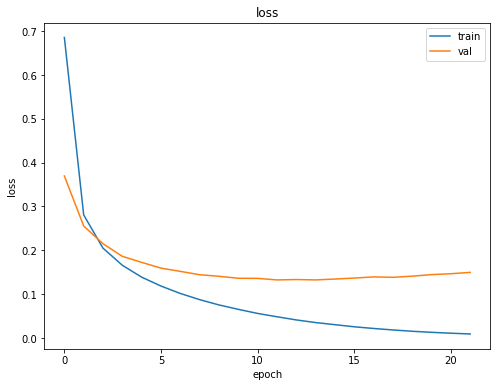

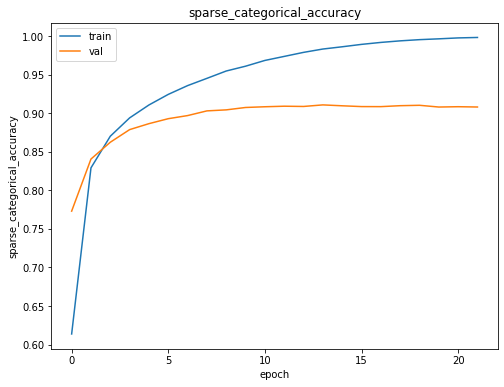

In [24]:
baseline_model = train_model(baseline_model, X_train, y_train, X_val, y_val, training_info)

### Variations
What follows is the implementation of small variations to the baseline architecture.

#### GRU
Change the LSTM layer with the GRU layer

In [25]:
# Create layers
baseline_var1_layers = [
                # embedding_layer(embedding_weights=embedding_weights),
                masking_layer(input_shape=(MAX_SEQUENCE_SIZE, EMBEDDING_SIZE),
                              layer_name='masking_0'),
                bigru_layer(layer_depth=1,
                            layer_name='bi-gru_0'),
                time_distributed_dense_layer(last_layer=True,
                                             layer_name='dense_0')
]

# Create the model
baseline_var1_model = create_model('baseline_var1', 
                              baseline_var1_layers, 
                              model_compile_info)

# Check if the model can actually run (used only for debug purpose)
# model_sanity_check(baseline_var1_model)

Model: "baseline_var1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_0 (Masking)         (None, 55, 200)           0         
                                                                 
 bi-gru_0 (Bidirectional)    (None, 55, 128)           102144    
                                                                 
 dense_0 (TimeDistributed)   (None, 55, 46)            5934      
                                                                 
Total params: 108,078
Trainable params: 108,078
Non-trainable params: 0
_________________________________________________________________


Start training! 
Parameters: {'verbose': 1, 'epochs': 100, 'batch_size': 8, 'callbacks': [<keras.callbacks.EarlyStopping object at 0x7f6a28621c90>]}
Epoch 1/100
246/246 [==============================] - 16s 31ms/step - loss: 0.3074 - sparse_categorical_accuracy: 0.8469 - val_loss: 0.1905 - val_sparse_categorical_accuracy: 0.8745
Epoch 2/100
246/246 [==============================] - 5s 19ms/step - loss: 0.1404 - sparse_categorical_accuracy: 0.9068 - val_loss: 0.1575 - val_sparse_categorical_accuracy: 0.8907
Epoch 3/100
246/246 [==============================] - 5s 19ms/step - loss: 0.1048 - sparse_categorical_accuracy: 0.9320 - val_loss: 0.1417 - val_sparse_categorical_accuracy: 0.9006
Epoch 4/100
246/246 [==============================] - 5s 19ms/step - loss: 0.0831 - sparse_categorical_accuracy: 0.9461 - val_loss: 0.1337 - val_sparse_categorical_accuracy: 0.9070
Epoch 5/100
246/246 [==============================] - 5s 19ms/step - loss: 0.0675 - sparse_categorical_accuracy: 0.9588 -

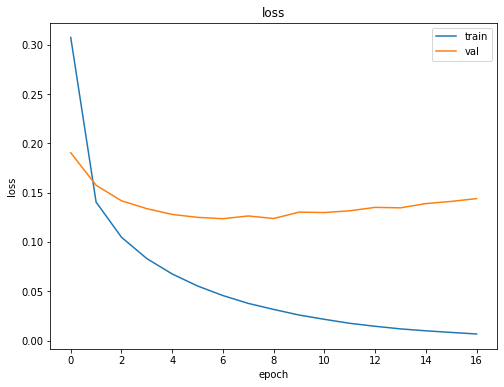

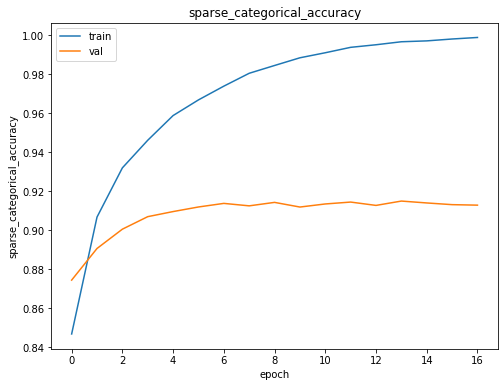

In [26]:
baseline_var1_model = train_model(baseline_var1_model, X_train, y_train, X_val, y_val, training_info)

#### Additional LSTM layer

In [27]:
# Create layers
baseline_var2_layers = [
                # embedding_layer(embedding_weights=embedding_weights),
                masking_layer(input_shape=(MAX_SEQUENCE_SIZE, EMBEDDING_SIZE),
                              layer_name='masking_0'),
                bilstm_layer(layer_depth=1,
                             layer_name='bi-lstm_0'),
                bilstm_layer(layer_depth=2,
                             layer_name='bi-lstm_1'),
                time_distributed_dense_layer(last_layer=True,
                                             layer_name='dense_0')
]

# Create the model
baseline_var2_model = create_model('baseline_var2', 
                              baseline_var2_layers, 
                              model_compile_info)

# Check if the model can actually run (used only for debug purpose)
# model_sanity_check(baseline_var2_model)

Model: "baseline_var2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_0 (Masking)         (None, 55, 200)           0         
                                                                 
 bi-lstm_0 (Bidirectional)   (None, 55, 128)           135680    
                                                                 
 bi-lstm_1 (Bidirectional)   (None, 55, 256)           263168    
                                                                 
 dense_0 (TimeDistributed)   (None, 55, 46)            11822     
                                                                 
Total params: 410,670
Trainable params: 410,670
Non-trainable params: 0
_________________________________________________________________


Start training! 
Parameters: {'verbose': 1, 'epochs': 100, 'batch_size': 8, 'callbacks': [<keras.callbacks.EarlyStopping object at 0x7f6a28621c90>]}
Epoch 1/100
246/246 [==============================] - 32s 59ms/step - loss: 0.3995 - sparse_categorical_accuracy: 0.8110 - val_loss: 0.1889 - val_sparse_categorical_accuracy: 0.8729
Epoch 2/100
246/246 [==============================] - 8s 35ms/step - loss: 0.1311 - sparse_categorical_accuracy: 0.9121 - val_loss: 0.1436 - val_sparse_categorical_accuracy: 0.8999
Epoch 3/100
246/246 [==============================] - 9s 35ms/step - loss: 0.0854 - sparse_categorical_accuracy: 0.9422 - val_loss: 0.1245 - val_sparse_categorical_accuracy: 0.9155
Epoch 4/100
246/246 [==============================] - 8s 35ms/step - loss: 0.0589 - sparse_categorical_accuracy: 0.9608 - val_loss: 0.1156 - val_sparse_categorical_accuracy: 0.9189
Epoch 5/100
246/246 [==============================] - 8s 34ms/step - loss: 0.0415 - sparse_categorical_accuracy: 0.9740 -

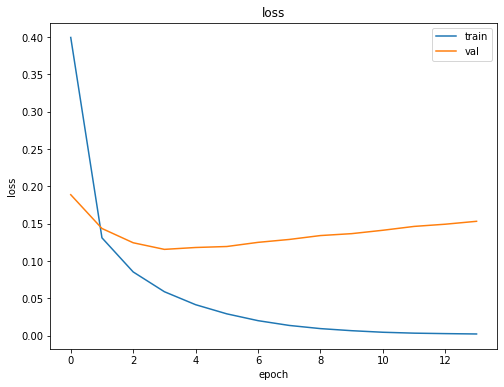

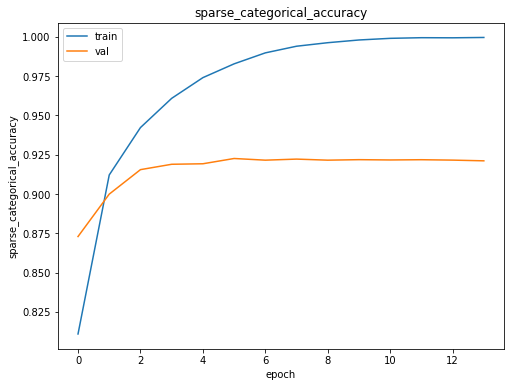

In [28]:
baseline_var2_model = train_model(baseline_var2_model, X_train, y_train, X_val, y_val, training_info)

#### Additional Dense layer

In [29]:
# Create layers
baseline_var3_layers = [
                # embedding_layer(embedding_weights=embedding_weights),
                masking_layer(input_shape=(MAX_SEQUENCE_SIZE, EMBEDDING_SIZE),
                              layer_name='masking_0'),
                bilstm_layer(layer_depth=1,
                             layer_name='bi-lstm_0'),
                time_distributed_dense_layer(last_layer=False,
                                             layer_name='dense_0'),
                time_distributed_dense_layer(last_layer=True,
                                             layer_name='dense_1')
]

# Create the model
baseline_var3_model = create_model('baseline_var3', 
                              baseline_var3_layers, 
                              model_compile_info)

# Check if the model can actually run (used only for debug purpose)
# model_sanity_check(baseline_var3_model)

Model: "baseline_var3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_0 (Masking)         (None, 55, 200)           0         
                                                                 
 bi-lstm_0 (Bidirectional)   (None, 55, 128)           135680    
                                                                 
 dense_0 (TimeDistributed)   (None, 55, 256)           33024     
                                                                 
 dense_1 (TimeDistributed)   (None, 55, 46)            11822     
                                                                 
Total params: 180,526
Trainable params: 180,526
Non-trainable params: 0
_________________________________________________________________


Start training! 
Parameters: {'verbose': 1, 'epochs': 100, 'batch_size': 8, 'callbacks': [<keras.callbacks.EarlyStopping object at 0x7f6a28621c90>]}
Epoch 1/100
246/246 [==============================] - 17s 32ms/step - loss: 0.2937 - sparse_categorical_accuracy: 0.8534 - val_loss: 0.1643 - val_sparse_categorical_accuracy: 0.8860
Epoch 2/100
246/246 [==============================] - 5s 19ms/step - loss: 0.1126 - sparse_categorical_accuracy: 0.9222 - val_loss: 0.1340 - val_sparse_categorical_accuracy: 0.9069
Epoch 3/100
246/246 [==============================] - 5s 20ms/step - loss: 0.0754 - sparse_categorical_accuracy: 0.9479 - val_loss: 0.1242 - val_sparse_categorical_accuracy: 0.9156
Epoch 4/100
246/246 [==============================] - 5s 19ms/step - loss: 0.0532 - sparse_categorical_accuracy: 0.9634 - val_loss: 0.1252 - val_sparse_categorical_accuracy: 0.9140
Epoch 5/100
246/246 [==============================] - 5s 20ms/step - loss: 0.0391 - sparse_categorical_accuracy: 0.9738 -

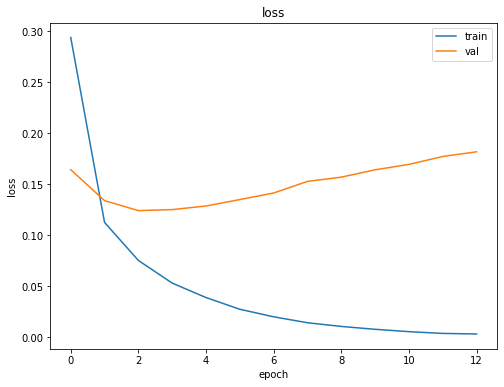

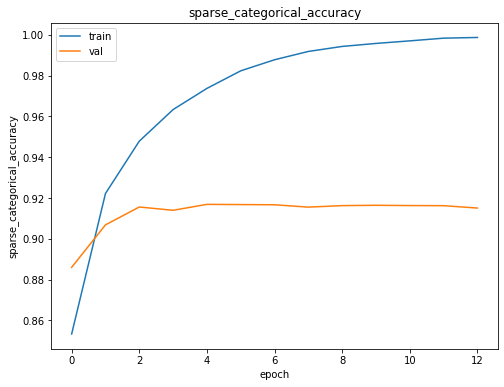

In [30]:
baseline_var3_model = train_model(baseline_var3_model, X_train, y_train, X_val, y_val, training_info)

## Test
Now proceed with testing the two best models found so far.

From our experiments, we have noticed that there isn't a big difference in the final accuracy:
* the *baseline* model is the slower to train, but can reach eventually a good accuracy
* the *baseline variations* give pretty similar results, and can reach higher accuracy in a less amount of time. 
* Those that gave us the best results are the models where we added an additional BI-LSTM layer and an additional Dense layer, respectively.

What follow is a list of utility methods used for testing the models.

In [31]:
def create_testing_labels():
    """
    Method for creating a list of labels indices and label descriptions 
    that must be used for testing.
    
    Returns
    -------
    labels : np.array
        List of labels (indices)
    labels_name: np.array
        Description of labels
    """

    labels = []
    labels_name = []
    for word, token in tqdm(labels_encoding.items()):
        if token != PADDING:
            if not is_punctuation_label(word):
                labels.append(token)
                labels_name.append(decode_label(token, labels_encoding))
    return labels, labels_name

# labels (indices and descriptions) used for testing
testing_labels, testing_label_names = create_testing_labels()

def show_f1_scores(metric_info):
    """
    Method for creating a list of labels that will be used for testing.
    
    Parameters
    -------
    metric_info : dict
        Dictionary that contains the f1 scores
    
    """
    print()
    print('F1 SCORES:')
    print(f'  macro: {metric_info["macro_f1"]}')
    print(f'  micro: {metric_info["micro_f1"]}')
    print(f'  weighted: {metric_info["weighted_f1"]}')
    print()

def show_classification_report(y_true, y_pred):
    """
    Method that prints the classification report
    
    Parameters
    -------
    y_true : np.array
        Array of true labels
    y_pred : np.array
        Array of predicted labels
    """

    print(classification_report(
        y_true, 
        y_pred, 
        labels=testing_labels,
        target_names=testing_label_names
        ))

def show_confusion_matrix(y_true, y_pred):
    """
    Method that shows the confusion matrix.
    
    Parameters
    -------
    y_true : np.array
        Array of true labels
    y_pred : np.array
        Array of predicted labels
    """
    fig, ax = plt.subplots(1,1,figsize=(25,25))
    plt.grid(visible=False)
    ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        normalize='true', 
        cmap=plt.cm.Blues, 
        values_format=".2f",
        labels=testing_labels,
        display_labels=testing_label_names,
        xticks_rotation='vertical',
        ax=ax)

100%|██████████| 45/45 [00:00<00:00, 128571.99it/s]


### Test model 1

Starting prediction: 
{'batch_size': 8, 'verbose': 1}
Predicting on 652 samples
82/82 [==============================] - 4s 5ms/step
Prediction evaluation started...

F1 SCORES:
  macro: 0.7433770462445008
  micro: 0.5235268203654366
  weighted: 0.8285458867303405

              precision    recall  f1-score   support

         NNP       0.06      0.88      0.11      1503
          CD       0.96      0.97      0.96       858
         NNS       0.87      0.92      0.89       941
          JJ       0.76      0.84      0.80       917
          MD       0.97      0.99      0.98       167
          VB       0.95      0.95      0.95       403
          DT       0.99      0.99      0.99      1335
          NN       0.90      0.86      0.88      2382
          IN       0.98      0.96      0.97      1630
         VBZ       0.94      0.95      0.95       280
         VBG       0.85      0.80      0.82       221
          CC       0.98      1.00      0.99       366
         VBD       0.93      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklear

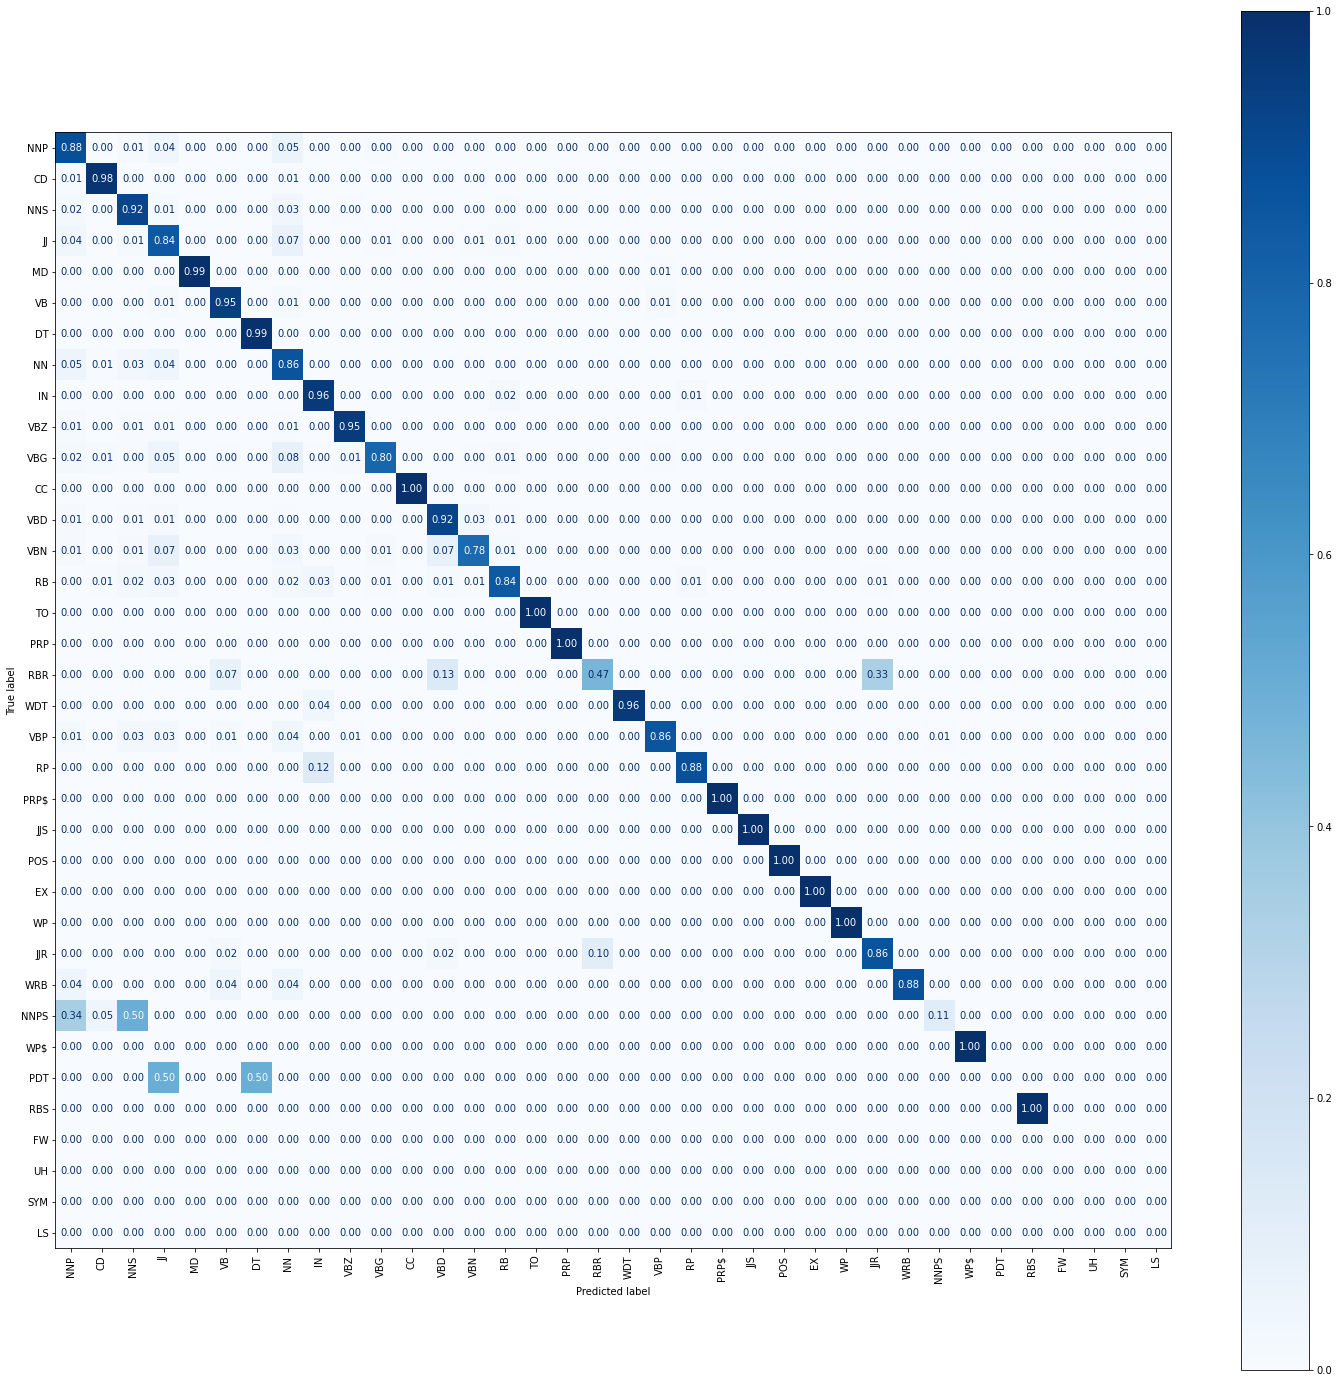

In [32]:
# Test first model and print results
metric_info, y_pred = test_model(
    baseline_var1_model, 
    testing_labels,
    X_test, 
    y_test)

show_f1_scores(metric_info)
show_classification_report(y_test.flatten(), y_pred.flatten())
show_confusion_matrix(y_test.flatten(), y_pred.flatten())

### Test model 2

Starting prediction: 
{'batch_size': 8, 'verbose': 1}
Predicting on 652 samples
82/82 [==============================] - 3s 6ms/step
Prediction evaluation started...

F1 SCORES:
  macro: 0.7132248644888538
  micro: 0.5240083069371315
  weighted: 0.8279258045065553

              precision    recall  f1-score   support

         NNP       0.06      0.86      0.11      1503
          CD       0.96      0.97      0.97       858
         NNS       0.88      0.90      0.89       941
          JJ       0.75      0.85      0.80       917
          MD       0.96      0.98      0.97       167
          VB       0.95      0.96      0.95       403
          DT       0.98      0.99      0.99      1335
          NN       0.90      0.87      0.88      2382
          IN       0.98      0.96      0.97      1630
         VBZ       0.93      0.96      0.95       280
         VBG       0.75      0.83      0.79       221
          CC       1.00      0.99      1.00       366
         VBD       0.93      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklear

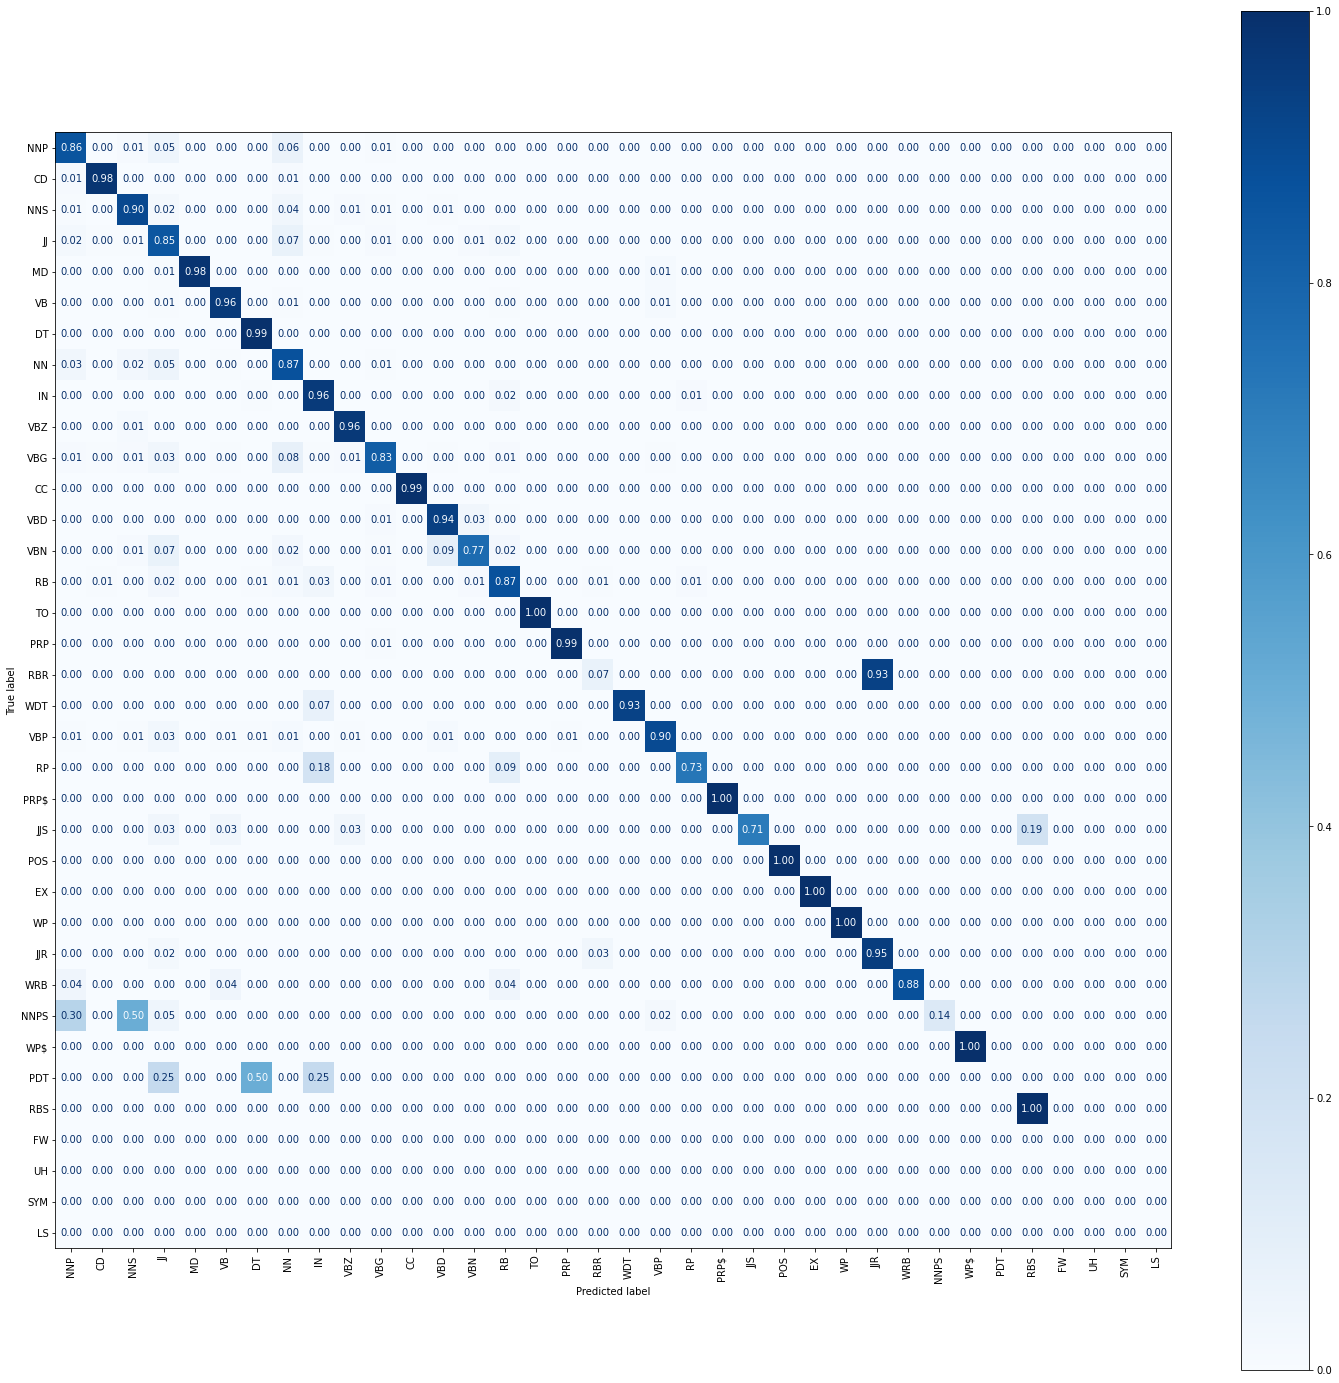

In [33]:
# Test second model and print results
metric_info, y_pred = test_model(
    baseline_var3_model, 
    testing_labels,
    X_test, 
    y_test)

show_f1_scores(metric_info)
show_classification_report(y_test.flatten(), y_pred.flatten())
show_confusion_matrix(y_test.flatten(), y_pred.flatten())

# Discussion and Error Analysis
In this part there is a small summary of the tests we have done, and the explanation of some choices that we made.

Finally, there are some considerations about the models that we selected for the final testing, and a comparison with the results obtained on the validation set.



## Hyper-parameters and strategies
The quantity of possible hyper-parameters and strategies combination is huge, e.g., the number of rnn hidden layers, the number of units for dense layers, the batch size, the normalization techniques, etc...

We fixed some of these empirically, and we focused our attention mainly on the following ones:
* activation function
* dataset split: documents vs sentences
* GloVe dimension
* OOV strategies

We tuned these hyper-parameters and strategies on the baseline model. Only once we've found the best combination, then we have implemented the model variations.

### Activation function
At the beginning we used the 'ReLu' activation functions in all layers, except the last Dense layer.
We discovered that this choice had two problems:
* ReLu is not supported from cuDNN kernel, which is the one that gives the higher computational speed
* the number of time steps is pretty large, especially when the dataset is splitted into documents. This was causing the network to become untrainable due to vanishing gradients.

Eventually, we decided to use the **Tanh** activation function which was able to overcome all the problems mentioned above.



### Dataset split: sentences vs documents
We tried both split types, and it is possibile to switch from one to another just by using the flag 'USE_DOCUMENTS'.

We noticed that, when splitted into **sentences**, the model generalizes better.

**Why?**

When splitting the *train* dataset into **documents** we have remarked that only ~30% of documents is using the full max_length (computed through quantile technique seen during the tutorials), and then there is **a lot of variability in the input length**.

Whereas, when we split the *train* dataset into **sentences**, the percentage of documents able to reach the full max_length is ~70%, and the **input length is more stable**.

Very similar reasonings can be done for the *test* set.

Thus, our thought is that the model would require a larger dataset in order to better cope with very different input lengths.

### GloVe dimension
It was the first time that we implemented GloVe. Therefore, we tested the model with different versions of the GloVe embedding.

We discovered that the training accuracy was 4% higher with dimension 200 compared to dimension 50, so we sticked with that.



### OOV management
For testing purposes we implemented 3 different types of OOV management: **random**, **placeholder** and **neighbours mean**. It is possible to test them all just by changing the variable "OOV_METHOD". 

The one that perfomed worse is **placeholder**: when using this type of OOV strategy, the final accuracy of the baseline model was lower with respect to the other methods.

Between **random** and **neighbours mean** we didn't notice big differences. However, we sticked with the latter because it was giving a minor accuracy improvement during the training of the baseline model.

## Error analysis
Although the model with an additional DENSE layer gives slightly better results, the two models that we selected and evaluated on the test set perform very similarly. Therefore, the following observations are valid for both of them.

First of all, it is possible to see a huge difference between the validation accuracy seen during the training, and the final accuracy of the tested models.

The main reason for this behaviour is related to the **class imbalance** problem, and it is remarkable in [THIS](#001) countplot shown previously in the notebook. For this reason, we have mainly used the **micro f1-score** for doing our evaluations.

In addition, as it is possibile to remark from the **warnings** obtained when showing the classification report and the confusion matrix, **some samples are either not present in the true labels or never predicted**. This could be seen as another signal that highlights a problem with the class distributions in the datasets.

Now, let's focus our attention on some classes, in particular on those that gave edge results (e.g., low, medium and high f1-scores).

#### **NNP (Proper noun, singular)**
* high number of occurences in the training set
* **low f1-score** on test set (low precision, high recall)
* missclassified with:
 * NNS (*Noun, plural*)
 * JJ (*Adjective*)
 * NN (*Noun, singular or mass*)

The model seems to be confused with other tags that are very common in the training set. Moreover, it is also quite intuitive that NNP could be easily missclassified with NNS and NN, which also represent nouns.

#### **MD (Modal)**
* low number of occurences in the training set
* **high f1-score** (high precision, high recall)
* no missclassifications

Even though the number of occurences in the training set is low, the model seems to be very effective in learning the correct tag of modal verbs.
Also in this case it could be quite intuitive understand why: modal verbs often have very precise and fixed positions in the english sentence structure.

#### **NNPS (Proper noun, plural)**
* very low number of occurences in the training set
* **low f1-score** on test set (medium-low precision, low recall)
* often missclassified with:
 * NNS (*Noun, plural*)
 * NNP (Proper noun, singular)

The model is not able to really distinguish between singular and plural nouns. The most probable reason is the very low number of occurences found in the training set.

#### **RP (Particle)**
* very low number of occurences in the training set
* **medium f1-score** (medium precision, high recall)
* often missclassified with:
 * IN (*Preposition or subordinating conjunction*)
 * RB (*Adverb*)

Particles are, by definition, similar to prepositions. Adding the fact that the RP class has a low representation in the training set, the model is not really able to understand which is the correct classification.

---

**In conclusion**, what we have noticed is that the model gets often fooled by similar tags that could be in the same position in an english sentence, or when the representation of a class in the training set is not really relevant for letting the model to properly learn them.

## Possible improvements
There are several techniques that could be used for improving the model performances, and what follows is a brief list of some of them: 
* **Gather more data**: this is probably the most difficult, yet the most effective, thing we could do. In this way we could reduce the class imbalance, and improve the model learning thanks to the increased number of samples.
* **Data augmentation**: this technique is very useful and commonly applied in several branches of machine learning and deep learning, especially when a dataset is small. 
* **Train, validation and test splits**: we could also work on the train, validation and test splits, so as to reduce data imbalance. In this way the model should be able to generalize better.
* **Attention and transformers**: attention mechanims and transformers could be very useful for improving the word representations, and for letting the model to focus its attention on relevant parts of the sentences.
* **Architectures**: better architectures could also help, and we also had a demonstration in this notebook, where the baseline model was outperformed by its variations.